In [1]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import zscore
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulinathrasher/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the dataset from Hugging Face
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)

# Access the full split and convert to pandas
df = dataset['full'].to_pandas()

In [3]:
# Simulate a review ID using the DataFrame index
df.reset_index(inplace=True)
df.rename(columns={'index': 'review_id'}, inplace=True)

# Convert UNIX timestamp to human-readable date
df['review_date'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')

# See all columns
print("Available columns:", df.columns.tolist())

# Summary of dataframe shape and types
print("\nData shape:", df.shape)
print("\nData types:\n", df.dtypes)

# Preview first few rows
df.head()

Available columns: ['review_id', 'rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'review_date']

Data shape: (701528, 12)

Data types:
 review_id                     int64
rating                      float64
title                        object
text                         object
images                       object
asin                         object
parent_asin                  object
user_id                      object
timestamp                     int64
helpful_vote                  int64
verified_purchase              bool
review_date          datetime64[ns]
dtype: object


,review_id,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,review_date
0,0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True,NaT
1,1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True,NaT
2,2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True,NaT
3,3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True,NaT
4,4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True,NaT


Basic Exploration



*   Provide summary statistics for numerical features (stars, helpful votes, etc.)
*   Create at least two visualizations of key features
*  Analyze the basic characteristics of review texts (length, common words)



In [4]:
#Numeric Columns First

numeric_cols = ['rating', 'helpful_vote']

# Summary stats
df[numeric_cols].describe()

,rating,helpful_vote
count,701528.000000,701528.000000
mean,3.960245,0.923588
std,1.494452,5.471391
min,1.000000,0.000000
25%,3.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,1.000000
max,5.000000,646.000000


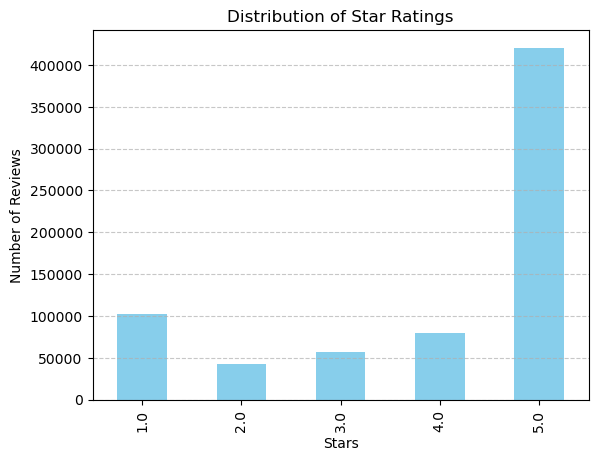

In [5]:
#Visualizing Key Features - Distribution of Star Ratings

df['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Star Ratings')
plt.xlabel('Stars')
plt.ylabel('Number of Reviews')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

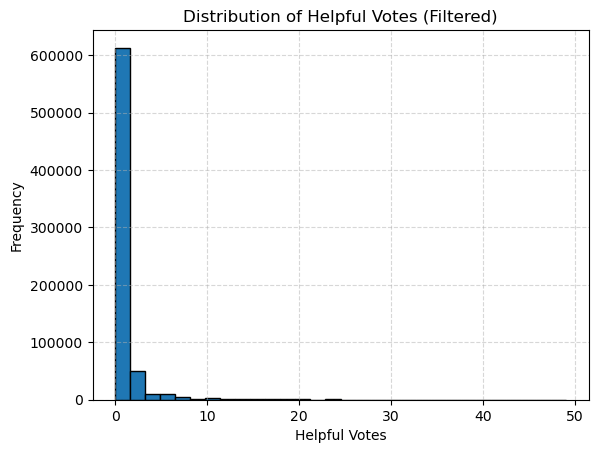

In [6]:
#Distribution of Key features

# Limit to reviews with <50 helpful votes to avoid skew
df[df['helpful_vote'] < 50]['helpful_vote'].plot.hist(bins=30, edgecolor='black')
plt.title('Distribution of Helpful Votes (Filtered)')
plt.xlabel('Helpful Votes')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

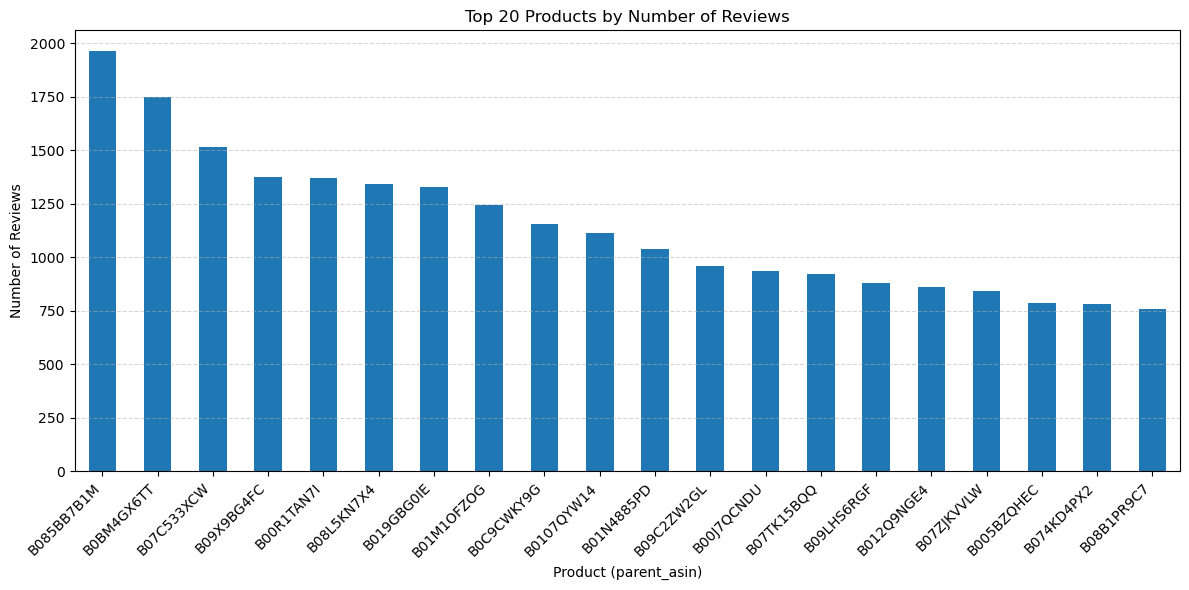

In [7]:
#Number of reviews per product
# Count reviews per product (using 'parent_asin' to group by product family)
product_review_counts = df['parent_asin'].value_counts().head(20)

# Plot
plt.figure(figsize=(12, 6))
product_review_counts.plot(kind='bar')
plt.title('Top 20 Products by Number of Reviews')
plt.xlabel('Product (parent_asin)')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [8]:
#Analyzing Review Text Characteristics - Review length

# Create a column for review length
df['review_length'] = df['text'].astype(str).apply(lambda x: len(x.split()))

df['review_length'].describe()

count    701528.000000
mean         32.750720
std          45.973273
min           0.000000
25%           8.000000
50%          19.000000
75%          40.000000
max        2585.000000
Name: review_length, dtype: float64

In [9]:
#Common words/word frequency

# Clean and tokenize review text
stop_words = set(stopwords.words('english'))

def tokenize(text):
    tokens = re.findall(r'\b\w+\b', str(text).lower())
    return [word for word in tokens if word not in stop_words]

# Apply to a sample to reduce processing time
sample_texts = df['text'].dropna().sample(n=5000, random_state=42)
all_words = []

for review in sample_texts:
    all_words.extend(tokenize(review))

# Get 20 most common words
common_words = Counter(all_words).most_common(20)
print("Top 20 Common Words:")
print(common_words)

Top 20 Common Words:
[('hair', 1358), ('great', 978), ('product', 969), ('br', 951), ('like', 923), ('love', 878), ('use', 837), ('good', 701), ('one', 578), ('well', 557), ('really', 549), ('skin', 488), ('would', 471), ('get', 442), ('time', 423), ('used', 407), ('nice', 395), ('easy', 372), ('works', 368), ('using', 343)]


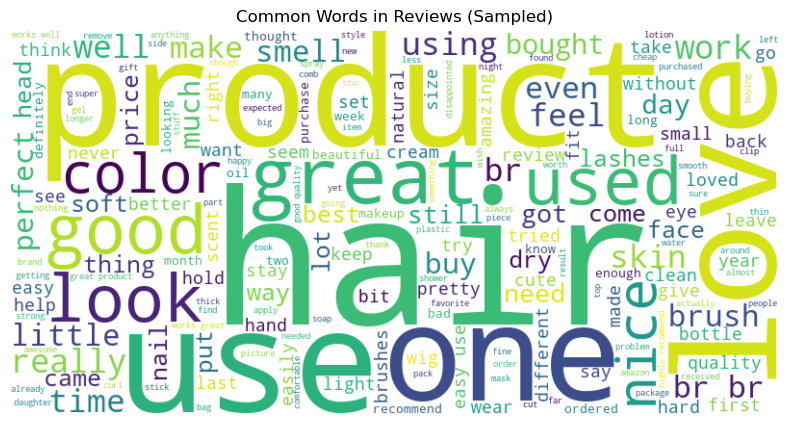

In [10]:
#World Cloud Visual

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(all_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Reviews (Sampled)')
plt.show()

Check for missing values

In [11]:
# Counting missing values
df.isnull().sum()

# Drop rows with missing review text
df.dropna(subset=['text'], inplace=True)

# Fill missing helpful_vote with 0 if needed
df['helpful_vote'].fillna(0, inplace=True)

/var/folders/97/39v4q5d17f39bcmmkl55tr940000gn/T/ipykernel_29813/3899901420.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['helpful_vote'].fillna(0, inplace=True)


Normalization of numeric values

In [12]:

# Feature Engineering: Create numeric ratios before scaling
df['length_per_star'] = df['review_length'] / df['rating']
df['helpful_per_word'] = df['helpful_vote'] / (df['review_length'] + 1)  # avoid divide-by-zero
df['helpful_per_star'] = df['helpful_vote'] / (df['rating'] + 1e-6)      # avoid divide-by-zero

# Log-transform skewed features
df['log_helpful_vote'] = np.log1p(df['helpful_vote'])
df['log_review_length'] = np.log1p(df['review_length'])

# Min-Max scale star ratings 
scaler = MinMaxScaler()
df['scaled_rating'] = scaler.fit_transform(df[['rating']])

scaler_num = MinMaxScaler()
df[['scaled_helpful_vote', 'scaled_helpful_per_word', 'scaled_helpful_per_star']] = scaler_num.fit_transform(
    df[['helpful_vote', 'helpful_per_word', 'helpful_per_star']]
)

Text Preprocessing - tokenization and stopword removal

In [13]:

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase, remove non-letters, tokenize
    text = str(text).lower()
    tokens = re.findall(r'\b[a-z]+\b', text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply to a new column
df['cleaned_text'] = df['text'].apply(clean_text)

TF-IDF Feature Extraction

In [14]:

# Limit to most frequent 1000 words
tfidf = TfidfVectorizer(max_features=1000)



# Fit and transform
tfidf_matrix = tfidf.fit_transform(df['cleaned_text'])

# Optional: turn into DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# View shape
print(tfidf_df.shape)
tfidf_df.head()

(701528, 1000)


,able,absolutely,absorbs,acne,across,actual,actually,add,added,adorable,...,would,wow,wrap,wrinkles,wrong,year,years,yellow,yes,yet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.156763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1.2: Anomaly Detection Implementation


1.   Statistical Method
2.   Clustering Based Method

Statistical Method Notes:

What Kinds of Reviews Are Flagged as Anomalies?
Here are typical examples of what will be detected:


*   Extremely long reviews with low ratings
*   Short reviews with very high helpful votes
*   Unusual review-to-star ratios
*   High helpfulness but low star rating

The scatter plot maps each review as a point using two of the computed features. Points flagged as anomalies (Z-score > 3) are colored differently, usually red.

Expect:
Most points form a cloud near the origin.

Anomalous points are scattered far from the dense cluster—often in corners or isolated areas.

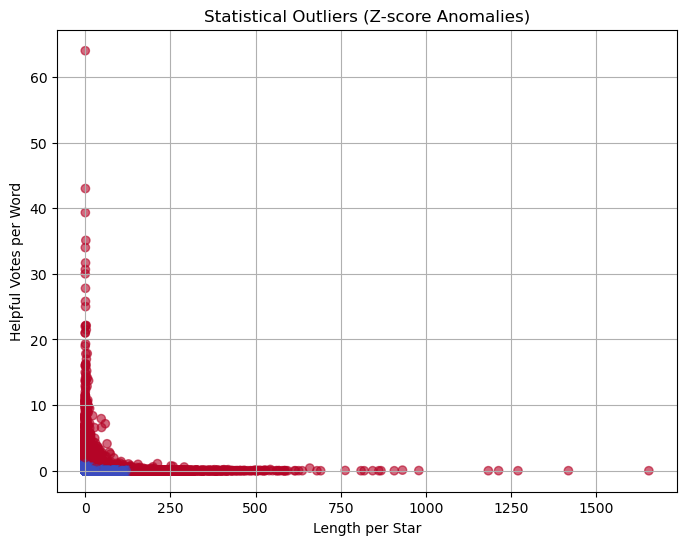


             Top 5 Anomalous Reviews (Statistical Method)             
                                          text  length_per_star  helpful_vote  helpful_per_word  helpful_per_star
                                       Amazing              0.2           128             64.00              25.6
                                     I like it              0.6           172             43.00              34.4
                                 Great product              0.4           118             39.33              23.6
It's a great touch up in between my tattooing.              1.8           351             35.10              70.2
                                  Doesn't work              0.4           102             34.00              20.4


In [15]:
#Method 1: Statistical Method using Z-Scores

#Compute Z-Scores

# Choose the numeric features to evaluate
z_features = ['length_per_star', 'helpful_vote', 'helpful_per_word', 'helpful_per_star']
df_z = df[z_features].apply(zscore)

# Set threshold for anomaly-> abs(Z) > 3 on any feature
# df['z_anomaly'] = df_z.abs().max(axis=1) > 3
#Z_SCORE TEST
df['z_distance'] = np.linalg.norm(df_z, axis=1)
threshold = df['z_distance'].quantile(0.99)
df['z_anomaly'] = df['z_distance'] > threshold

#Visualize the anomalies
plt.figure(figsize=(8, 6))
plt.scatter(df['length_per_star'], df['helpful_per_word'], c=df['z_anomaly'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Length per Star')
plt.ylabel('Helpful Votes per Word')
plt.title('Statistical Outliers (Z-score Anomalies)')
plt.grid(True)
plt.show()

# Sort anomalies by most extreme helpful_per_word values (or any other metric you prefer)
stat_anomalies = df[df['z_anomaly']].copy()
top_stat_anomalies = stat_anomalies.sort_values('helpful_per_word', ascending=False).head(5)

stat_table = top_stat_anomalies[['text', 'length_per_star', 'helpful_vote', 'helpful_per_word', 'helpful_per_star']].copy()
stat_table[['length_per_star', 'helpful_per_word', 'helpful_per_star']] = stat_table[['length_per_star', 'helpful_per_word', 'helpful_per_star']].round(2)
# Display tables
print("\n" + "="*70)
print("Top 5 Anomalous Reviews (Statistical Method)".center(70))
print("="*70)
print(stat_table.to_string(index=False))

In [16]:
#Counts of anomalies vs normal points:

# Count anomalies vs. normal reviews
anomaly_counts = df['z_anomaly'].value_counts()

# Display raw counts
print("Anomaly counts:\n", anomaly_counts)

# Calculate and display proportions
total = len(df)
proportion_anomalies = anomaly_counts[True] / total
proportion_normals = anomaly_counts[False] / total

print(f"\nProportion of anomalies: {proportion_anomalies:.4f} ({proportion_anomalies:.2%})")
print(f"Proportion of normal reviews: {proportion_normals:.4f} ({proportion_normals:.2%})")

Anomaly counts:
 z_anomaly
False    694517
True       7011
Name: count, dtype: int64

Proportion of anomalies: 0.0100 (1.00%)
Proportion of normal reviews: 0.9900 (99.00%)


In [17]:
# Identify which feature had the highest absolute Z-score per anomaly
df['max_z_feature'] = df_z.abs().idxmax(axis=1)

# Count the frequency of top contributing features for anomalies
z_feature_counts = df[df['z_anomaly']]['max_z_feature'].value_counts()

# Display the result
print("\n" + "="*70)
print("Feature Responsible for Most Z-Anomalies".center(70))
print("="*70)
print(z_feature_counts.to_string())


               Feature Responsible for Most Z-Anomalies               
max_z_feature
length_per_star     2786
helpful_vote        1744
helpful_per_star    1265
helpful_per_word    1216


K-Means Clustering Notes

1. PCA visual
Each review (via PCA-reduced TF-IDF vectors) is a point, Colors represent cluster membership (e.g., Cluster 0 to Cluster 4).
    *  Red points are reviews far from their cluster centers—flagged as anomalies.

2. Since K-Means is clustering based on text similarity (via TF-IDF), anomalies will be reviews that use unusual vocabulary, tone, or format compared to the rest.



In [18]:

# Load a compact model (good balance of speed and quality)
# model = SentenceTransformer('all-MiniLM-L6-v2')
#Trying a different model
model = SentenceTransformer('paraphrase-MiniLM-L12-v2')
#Another new option
# model = SentenceTransformer('all-mpnet-base-v2')

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Best k: 2 with silhouette score: 0.0999
Silhouette Score (Embeddings): 0.1297


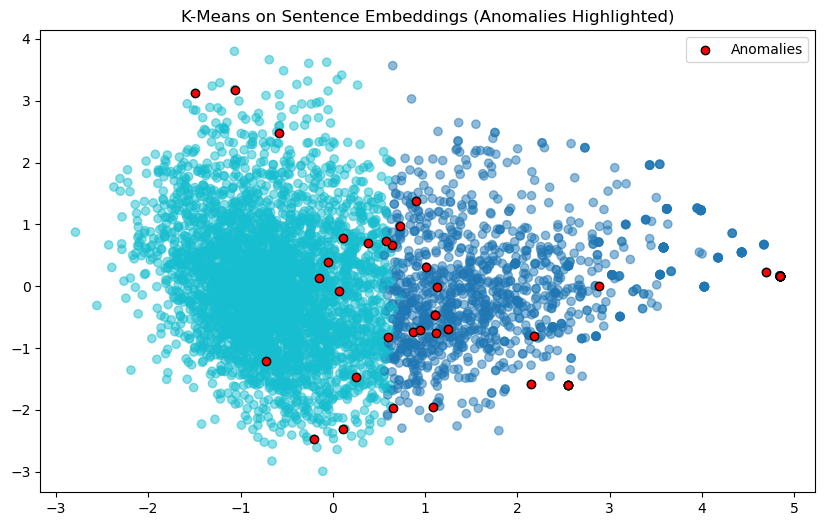

In [19]:
# Generate embeddings (returns a NumPy array)
sample_df = df.sample(n=5000, random_state=42).reset_index(drop=True)
embeddings = model.encode(sample_df['cleaned_text'], show_progress_bar=True)

pca_50 = PCA(n_components=50)
reduced_embeddings = pca_50.fit_transform(embeddings)

best_k = 0
best_score = -1
scores = []

for k in range(2, 10):
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    labels = kmeans_test.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    scores.append((k, score))
    if score > best_score:
        best_k = k
        best_score = score

print(f"\nBest k: {best_k} with silhouette score: {best_score:.4f}")

kmeans = KMeans(n_clusters=best_k, random_state=42)
sample_df['cluster'] = kmeans.fit_predict(reduced_embeddings)

# Distance to nearest cluster center
distances = kmeans.transform(reduced_embeddings)
sample_df['distance_to_center'] = np.min(distances, axis=1)


# Flag top 1% farthest as anomalies
threshold = sample_df['distance_to_center'].quantile(0.99)
sample_df['cluster_anomaly'] = sample_df['distance_to_center'] > threshold

score = silhouette_score(reduced_embeddings, sample_df['cluster'])

print(f"Silhouette Score (Embeddings): {score:.4f}")

pca = PCA(n_components=2)
reduced = pca.fit_transform(reduced_embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=sample_df['cluster'], cmap='tab10', alpha=0.5)
plt.scatter(
    reduced[sample_df['cluster_anomaly']][:, 0],
    reduced[sample_df['cluster_anomaly']][:, 1],
    color='red', edgecolor='black', label='Anomalies'
)
plt.title('K-Means on Sentence Embeddings (Anomalies Highlighted)')
plt.legend()
plt.show()

In [ ]:
# Get 5 anomalous reviews, sorted by distance from center (most extreme first)
anomalies = sample_df[sample_df['cluster_anomaly'] == True]

top_anomalies = anomalies.sort_values('distance_to_center', ascending=False).head(5)

cluster_table = top_anomalies[['text', 'length_per_star', 'helpful_vote', 'helpful_per_word', 'helpful_per_star', 'distance_to_center']].copy()
cluster_table[['length_per_star', 'helpful_per_word', 'helpful_per_star', 'distance_to_center']] = cluster_table[['length_per_star', 'helpful_per_word', 'helpful_per_star', 'distance_to_center']].round(2)
print("\n" + "="*70)
print("Top 5 Anomalous Reviews (Clustering Method)".center(70))
print("="*70)
print(cluster_table.to_string(index=False))